In [2]:
import os
import matplotlib.pyplot as plt

from lvmdrp.utils.examples import get_frames_metadata

from lvmdrp.functions import imageMethod
from lvmdrp.functions import rssMethod

plt.style.use("seaborn-v0_8-talk")

In [3]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = os.path.join("data")
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.{ext}")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.{ext}")

# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "sim_2d"))
# group by imagetyp, camera and exptime
frames_table = frames_table.group_by(["imagetyp", "spec", "camera", "expnum", "exptime"])
# define groups and unique categories in those groups
frames_groups = frames_table.groups
unique_groups = frames_groups.keys

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/frames_table.pkl'


imagetyp spec  mjd  camera  expnum  exptime                                           path                                         
-------- ---- ----- ------ -------- ------- ---------------------------------------------------------------------------------------
    flat  sp1 60023     b1 00001002    10.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/sdR-s-b1-00001002.fits.gz
    flat  sp1 60023     r1 00001002    10.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/sdR-s-r1-00001002.fits.gz
    flat  sp1 60023     z1 00001002    10.0 /home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/sim_2d/sdR-s-z1-00001002.fits.gz
[INFO]: selecting column = 1870 to locate fibers
[INFO]: locating fibers
[INFO]: found 663 fibers
[INFO]: refining fiber location
[INFO]: final number of fibers found 663


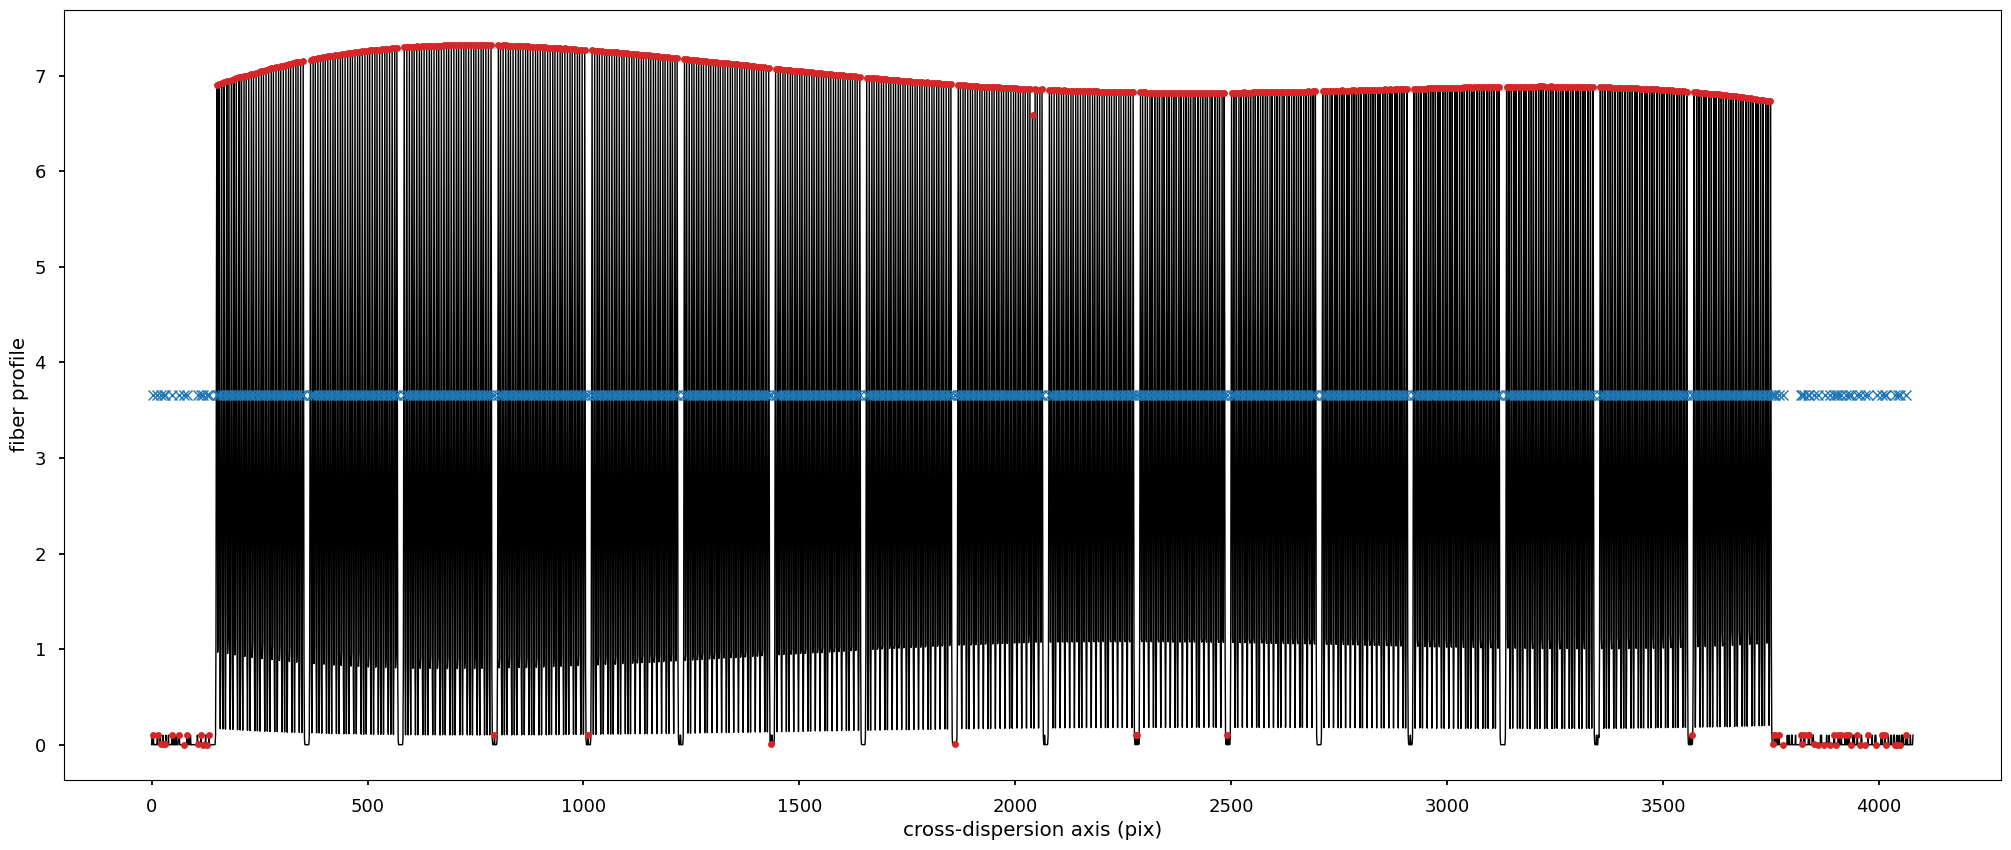

[INFO]: tracing fibers along dispersion axis


tracing fiber left from pixel 1870:   1%|6                                                          | 21/1870 [00:00<00:09, 204.30pixel/s]

[WARNING]: divide by zero encountered in divide (RuntimeWarning)


tracing fiber left from pixel 1870:   6%|###5                                                      | 115/1870 [00:00<00:07, 232.74pixel/s]

[WARNING]: invalid value encountered in divide (RuntimeWarning)


tracing fiber right from pixel 1870: 100%|########################################################| 2210/2210 [00:08<00:00, 253.03pixel/s]


[INFO]: fitting trace with 2-deg polynomial
[WARNING]: divide by zero encountered in scalar divide (RuntimeWarning)
[WARNING]: divide by zero encountered in scalar divide (RuntimeWarning)
[WARNING]: invalid value encountered in add (RuntimeWarning)


LinAlgError: SVD did not converge in Linear Least Squares

In [4]:
# expected number of fibers per spec 648

fiberflats = frames_groups[(unique_groups["imagetyp"]=="flat")&(unique_groups["spec"]=="sp1")&(unique_groups["expnum"]=="00001002")]
fiberflats.pprint()

for fiberflat_frame in fiberflats:
    fiberflat_path = fiberflat_frame["path"]
    fiberflat_camera, fiberflat_expnum = fiberflat_frame["camera"], fiberflat_frame["expnum"]

    imageMethod.findPeaksAuto_drp(
        in_image=out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_peaks=out_main_path.format(kind="peaks", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="txt"),
        nfibers=648, slice=1870, threshold=1, method="hyperbolic", median_box=5, median_cross=1, plot=1
    )

    imageMethod.tracePeaks_drp(
        in_image=out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        in_peaks=out_main_path.format(kind="peaks", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="txt"),
        steps=30, coadd=30, threshold_peak=1, max_diff=2, method="hyperbolic", median_box=5, median_cross=1,
        poly_disp=2, plot=1
    )

    imageMethod.extractSpec_drp(
        in_image=out_main_path.format(kind="cfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        out_rss=out_main_path.format(kind="xfiberflat", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        in_trace=out_main_path.format(kind="trace", camera=fiberflat_camera, expnum=fiberflat_expnum, ext="fits"),
        method="aperture", aperture=5, plot=1, parallel="auto"
    )